In [1]:
import os
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import json

from tqdm import tqdm

In [2]:
import warnings

warnings.filterwarnings('ignore')

In [3]:
sns.set_context("notebook")
sns.set_style("dark")

In [4]:
use_example = False
min_event_amount = 0

if use_example:
    with open("example-real-data.json", "rb") as f:
        old_raw_data = json.load(f)
else:
    old_raw_data = {"data": []}
    files = os.listdir("./data/")
    for file in files:
        if file.endswith(".json"):

            with open(f"data/{file}", "rb") as f:
                match_data = json.load(f)
                match_ts = file.replace(".json", "")
                if len(match_data["data"]) < min_event_amount:
                    continue

                match_start_data = [e for e in match_data["data"] if e["Type"] == "MatchStart"][0]

                # Don't account for PvE missions
                if "pve" in match_start_data["mission"].lower():
                    continue

                print(file)
                old_raw_data["data"] += [{**el, "match_ts": match_ts, "file": file} for el in match_data["data"]]

2024-04-08T17-57-23.289921.json
2024-04-08T18-17-34.219437.json
2024-04-08T19-07-00.347795.json
2024-04-08T19-33-48.870354.json
2024-04-08T19-53-27.765963.json
2024-04-08T20-06-40.070965.json
2024-04-08T20-22-46.301736.json
2024-04-12T17-44-52.448149.json
2024-04-12T18-03-12.027869.json
2024-04-12T18-21-33.203604.json
2024-04-12T18-39-11.125702.json
2024-04-12T18-54-11.940704.json
2024-04-12T19-04-19.770075.json
2024-04-12T19-29-31.102778.json
2024-04-12T19-45-44.724401.json
2024-04-12T19-53-17.540552.json
2024-04-12T19-59-09.133876.json
2024-04-14T18-13-45.253146.json
2024-04-14T18-26-32.823092.json
2024-04-14T19-09-10.930586.json
2024-04-14T19-24-55.631942.json
2024-04-14T20-26-42.676706.json
2024-04-14T20-39-33.127308.json
2024-04-14T20-48-35.562484.json
2024-04-15T18-20-16.174294.json
2024-04-15T18-43-35.535165.json
2024-04-15T18-57-54.250960.json
2024-04-15T19-26-07.189262.json
2024-04-15T20-15-46.828549.json
2024-04-15T20-31-44.891284.json
2024-04-15T20-42-38.643981.json
2024-04-

In [5]:
len(old_raw_data["data"])

681049

## Loading raw data from analytics system

In [8]:
is_veteran_regex = r'\w+(?!\-TacticalAV$)\-\w*V\w*|Terminator.*'

In [9]:
merge_lsm_and_csm = True

In [10]:
show_outliers = False
share_x = 'all'

In [11]:
raw_data = []
debug_string = ""
for el in old_raw_data["data"]:
    # Value
    if "value" in el:
        el["value"] = float(el["value"])

    # Merge CSM into LSM faction except support
    if merge_lsm_and_csm:
        if "if" in el and "il" in el:
            debug_string += f"I {el['if']} {el['il']}\r\n"
            if el["if"] == "CSM" and el["il"] not in ["SupS", "SupportVeteran"]:
                el["if"] = "LSM"
        if "tf" in el and "tl" in el:
            debug_string += f"T {el['tf']} {el['tl']}\r\n"
            if el["tf"] == "CSM" and el["tl"] not in ["SupS", "SupportVeteran"]:
                el["tf"] = "LSM"

    # Unique ts of match
    if "i" in el:
        el["i"] = el["i"] + "-" + el["match_ts"]
    if "t" in el:
        el["t"] = el["t"] + "-" + el["match_ts"]
    if "ips" in el:
        el["ips"] = el["ips"] + "-" + el["match_ts"]
    if "tps" in el:
        el["tps"] = el["tps"] + "-" + el["match_ts"]

    # Classes
    if "il" in el and "if" in el:
        el["i-faction-class"] = el["if"] + "-" + el["il"]
        el["i-is-veteran"] = bool(re.search(is_veteran_regex, el["i-faction-class"]))

    if "tl" in el and "tf" in el:
        el["t-faction-class"] = el["tf"] + "-" + el["tl"]
        el["t-is-veteran"] = bool(re.search(is_veteran_regex, el["t-faction-class"]))

    # Instigator coords
    if "ic" in el:
        el["ic_x"] = float(el["ic"].split(" ")[0].split("=")[1])
    if "ic" in el:
        el["ic_y"] = float(el["ic"].split(" ")[1].split("=")[1])

    # Target coords
    if "tc" in el:
        el["tc_x"] = float(el["tc"].split(" ")[0].split("=")[1])
    if "tc" in el:
        el["tc_y"] = float(el["tc"].split(" ")[1].split("=")[1])

    raw_data.append(el)

## Analyzing damage (per pawn, per class)

In [12]:
damage_df = pd.DataFrame([el for el in raw_data if el["Type"] == "Damage"])

In [13]:
# Removing friendly fire when analyzing damage
if not merge_lsm_and_csm:
    damage_df = damage_df[damage_df["if"] != damage_df["tf"]]

# Leave only damage from characters to characters
damage_df = damage_df[damage_df['i'].str.startswith("CH_") | damage_df['i'].str.startswith("ECRCharacter_")]
damage_df = damage_df[damage_df['t'].str.startswith("CH_") | damage_df['i'].str.startswith("ECRCharacter_")]

In [14]:
damage_per_pawn = damage_df.groupby(["i"]).agg(
    damage_per_life=('value', 'sum'),
    loadout=('i-faction-class', 'first'),
    is_veteran=('i-is-veteran', 'first'),
    faction=('if', 'first'),
)

In [15]:
median_damage_per_not_vet_pawn = damage_per_pawn[~damage_per_pawn["is_veteran"]]["damage_per_life"].median()

In [16]:
damage_per_life_for_classes = damage_per_pawn.sort_values(by='loadout').groupby("loadout").agg(
    mean_damage_per_life=('damage_per_life', 'mean'),
    std_damage_per_life=('damage_per_life', 'std')
)
damage_per_life_for_classes

,mean_damage_per_life,std_damage_per_life
loadout,,
CSM-SupS,264.149659,369.554489
CSM-SupportVeteran,946.214532,970.010788
LSM-ATGMLauncherVeteran,1228.981080,1152.649305
LSM-AucV,1179.599040,1055.640338
LSM-GravCannonStandard,452.929565,454.024257
LSM-HboS,665.085933,738.256835
LSM-JpaS,488.180314,538.360608
LSM-JpaVA,975.202503,1002.622870
LSM-LcaS,710.573369,858.276592


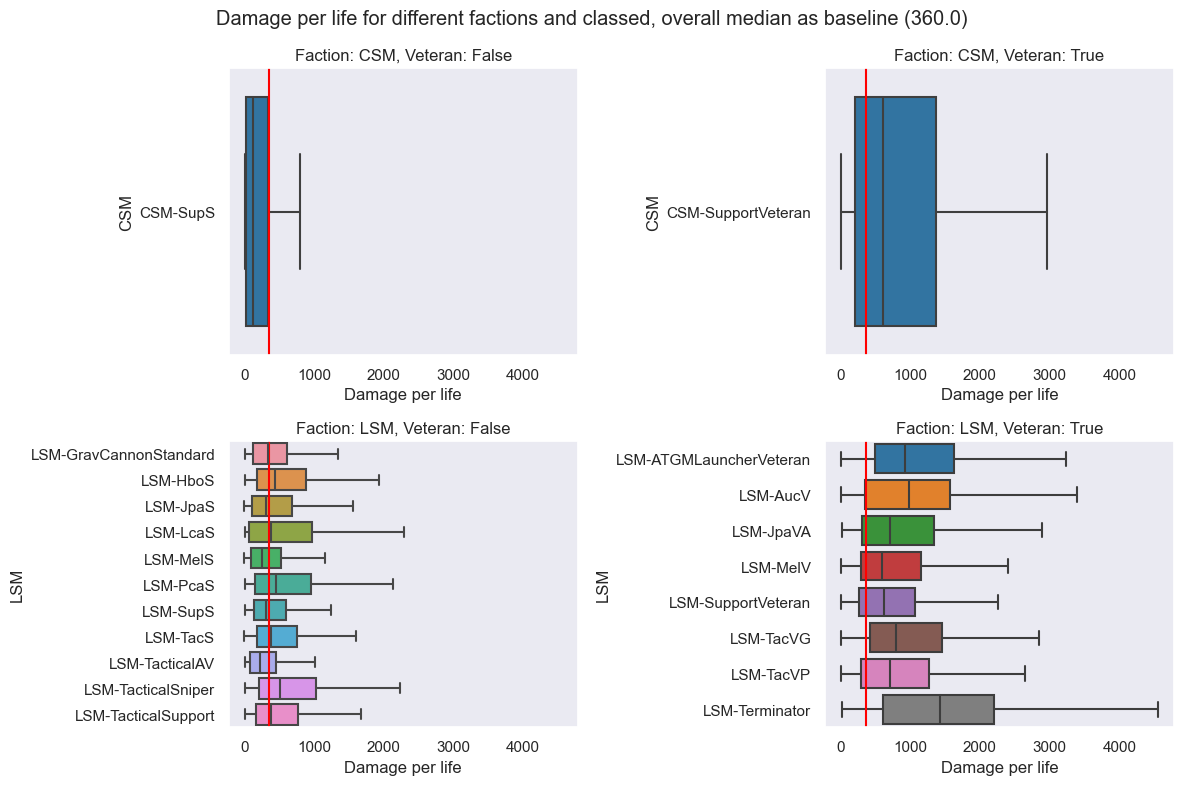

In [17]:
# Create a grid of subplots
fig, axes = plt.subplots(
    nrows=len(damage_per_pawn['faction'].unique()),
    ncols=len(damage_per_pawn['is_veteran'].unique()),
    figsize=(12, 8),
    sharex=share_x
)

# Grouping into subplots
for ((faction, veteran), subset), ax in zip(damage_per_pawn.groupby(['faction', 'is_veteran']), axes.flat):
    subset = subset.sort_values(by='loadout')  # Sort by 'loadout'
    sns.boxplot(x='damage_per_life', y='loadout', data=subset, ax=ax, orient='h', showfliers=show_outliers)

    # Set titles and axis labels
    ax.set_title(f'Faction: {faction}, Veteran: {veteran}')
    ax.set_xlabel('Damage per life')
    ax.set_ylabel(faction)

    ax.axvline(x=median_damage_per_not_vet_pawn, color='red')

    # Set x-axis ticks for each subplot
    ax.tick_params(axis='x', labelbottom=True)

fig.suptitle(f"Damage per life for different factions and classed, overall median as baseline ({median_damage_per_not_vet_pawn:.1f})")

# Adjust layout
plt.tight_layout()
plt.show()

## Analyzing XP (per pawn, per class and action)

In [18]:
xp_df = pd.DataFrame([el for el in raw_data if el["Type"] == "XP"])

# Leave only XP to characters
xp_df = xp_df[xp_df['t'].str.startswith("CH_") | damage_df['i'].str.startswith("ECRCharacter_")]

# Leave only damage from characters to characters
xp_df = xp_df[xp_df['t'].str.startswith("CH_") | xp_df['t'].str.startswith("ECRCharacter_")]

xp_df.head()

,t,value,tps,tf,tl,tc,action,Type,match_ts,file,t-faction-class,t-is-veteran,tc_x,tc_y
0,ECRCharacter_SpaceMarine_C_2147477994-2024-04-...,50.0,PS_2147479714-2024-04-08T17-57-23.289921,LSM,TacticalAV,X=19389.700 Y=3899.350 Z=-1092.030,Assist,XP,2024-04-08T17-57-23.289921,2024-04-08T17-57-23.289921.json,LSM-TacticalAV,False,19389.70,3899.35
1,ECRCharacter_SpaceMarine_C_2147477838-2024-04-...,100.0,PS_2147481031-2024-04-08T17-57-23.289921,LSM,GravCannonStandard,X=17639.260 Y=1743.280 Z=-1529.790,Enemy down,XP,2024-04-08T17-57-23.289921,2024-04-08T17-57-23.289921.json,LSM-GravCannonStandard,False,17639.26,1743.28
2,ECRCharacter_SpaceMarine_C_2147477838-2024-04-...,50.0,PS_2147481031-2024-04-08T17-57-23.289921,LSM,GravCannonStandard,X=17760.210 Y=2027.820 Z=-1520.020,Enemy finished,XP,2024-04-08T17-57-23.289921,2024-04-08T17-57-23.289921.json,LSM-GravCannonStandard,False,17760.21,2027.82
3,ECRCharacter_SpaceMarine_C_2147477883-2024-04-...,50.0,PS_2147480037-2024-04-08T17-57-23.289921,LSM,TacS,X=29238.080 Y=-9956.110 Z=-737.940,Assist,XP,2024-04-08T17-57-23.289921,2024-04-08T17-57-23.289921.json,LSM-TacS,False,29238.08,-9956.11
4,ECRCharacter_SpaceMarine_C_2147477659-2024-04-...,100.0,PS_2147482152-2024-04-08T17-57-23.289921,LSM,TacticalSniper,X=27179.620 Y=-8015.180 Z=320.060,Enemy down,XP,2024-04-08T17-57-23.289921,2024-04-08T17-57-23.289921.json,LSM-TacticalSniper,False,27179.62,-8015.18


In [19]:
xp_per_pawn_and_action = xp_df.groupby(["t", "action"]).agg(
    xp_per_life=('value', 'sum'),
    loadout=('t-faction-class', 'first'),
    is_veteran=('t-is-veteran', 'first'),
    faction=('tf', 'first')
)

In [20]:
xp_per_pawn = xp_df.groupby("t").agg(
    xp_per_life=('value', 'sum'),
    loadout=('t-faction-class', 'first'),
    is_veteran=('t-is-veteran', 'first'),
    faction=('tf', 'first')
)

In [21]:
xp_per_life_for_class_and_action = xp_per_pawn_and_action.groupby(["loadout", "action"]).agg(
    mean_xp_per_life=('xp_per_life', 'mean'),
    std_xp_per_life=('xp_per_life', 'std'),
    is_veteran=('is_veteran', 'first'),
    faction=('faction', 'first')
)

In [22]:
xp_per_life_for_class = xp_per_pawn.groupby(["loadout"]).agg(
    mean_xp_per_life=('xp_per_life', 'mean'),
    std_xp_per_life=('xp_per_life', 'std')
)
xp_per_life_for_class

,mean_xp_per_life,std_xp_per_life
loadout,,
CSM-SupS,363.099515,439.813721
CSM-SupportVeteran,700.768421,614.698827
LSM-ATGMLauncherVeteran,515.435897,504.497494
LSM-AucV,527.601810,460.088079
LSM-GravCannonStandard,316.666667,283.068400
LSM-HboS,373.222552,390.356894
LSM-JpaS,369.148176,374.178083
LSM-JpaVA,546.983425,574.769002
LSM-LcaS,421.698113,434.308365


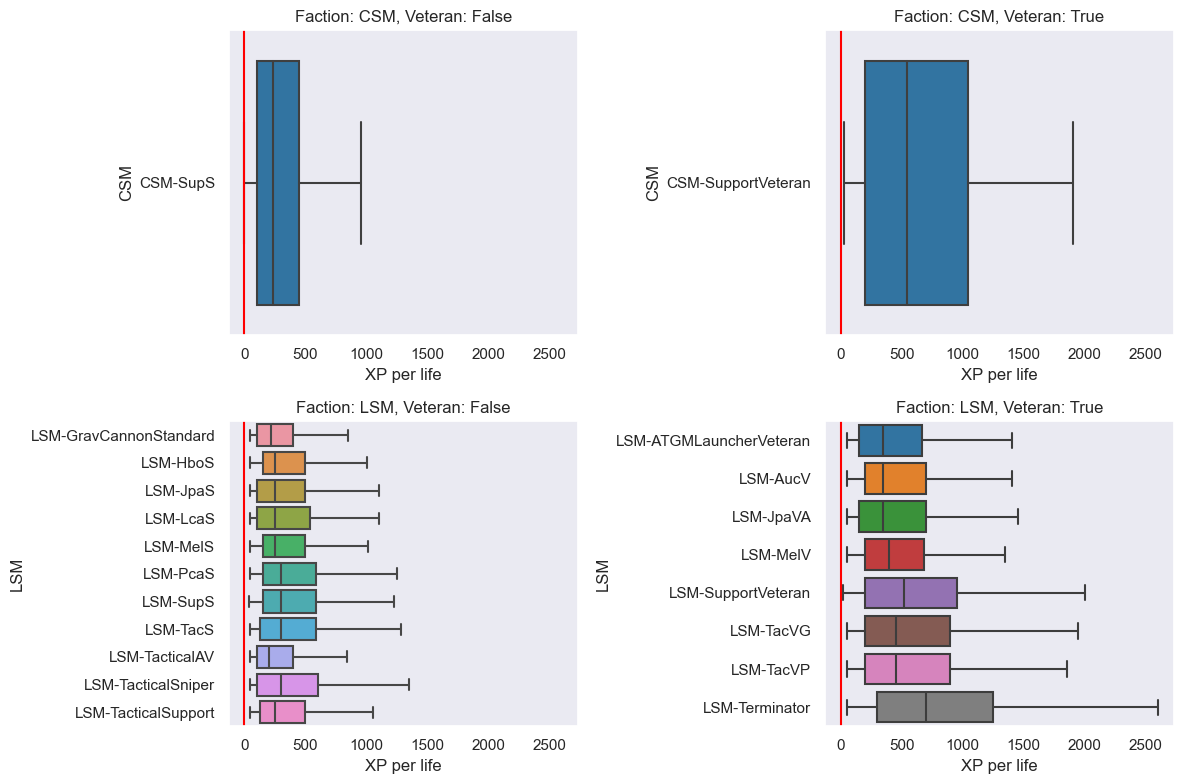

In [23]:
# Create a grid of subplots
fig, axes = plt.subplots(
    nrows=len(xp_per_pawn['faction'].unique()),
    ncols=len(xp_per_pawn['is_veteran'].unique()),
    figsize=(12, 8),
    sharex=share_x
)

# Grouping into subplots
for ((faction, veteran), subset), ax in zip(xp_per_pawn.groupby(['faction', 'is_veteran']), axes.flat):
    subset = subset.sort_values(by='loadout')  # Sort by 'loadout'
    sns.boxplot(x='xp_per_life', y='loadout', data=subset, ax=ax, orient='h', showfliers=show_outliers)

    # Set titles and axis labels
    ax.set_title(f'Faction: {faction}, Veteran: {veteran}')
    ax.set_xlabel('XP per life')
    ax.set_ylabel(faction)

    # Set x-axis ticks for each subplot
    ax.tick_params(axis='x', labelbottom=True)

    ax.axvline(x=0, color='red')

# Adjust layout
plt.tight_layout()
plt.show()

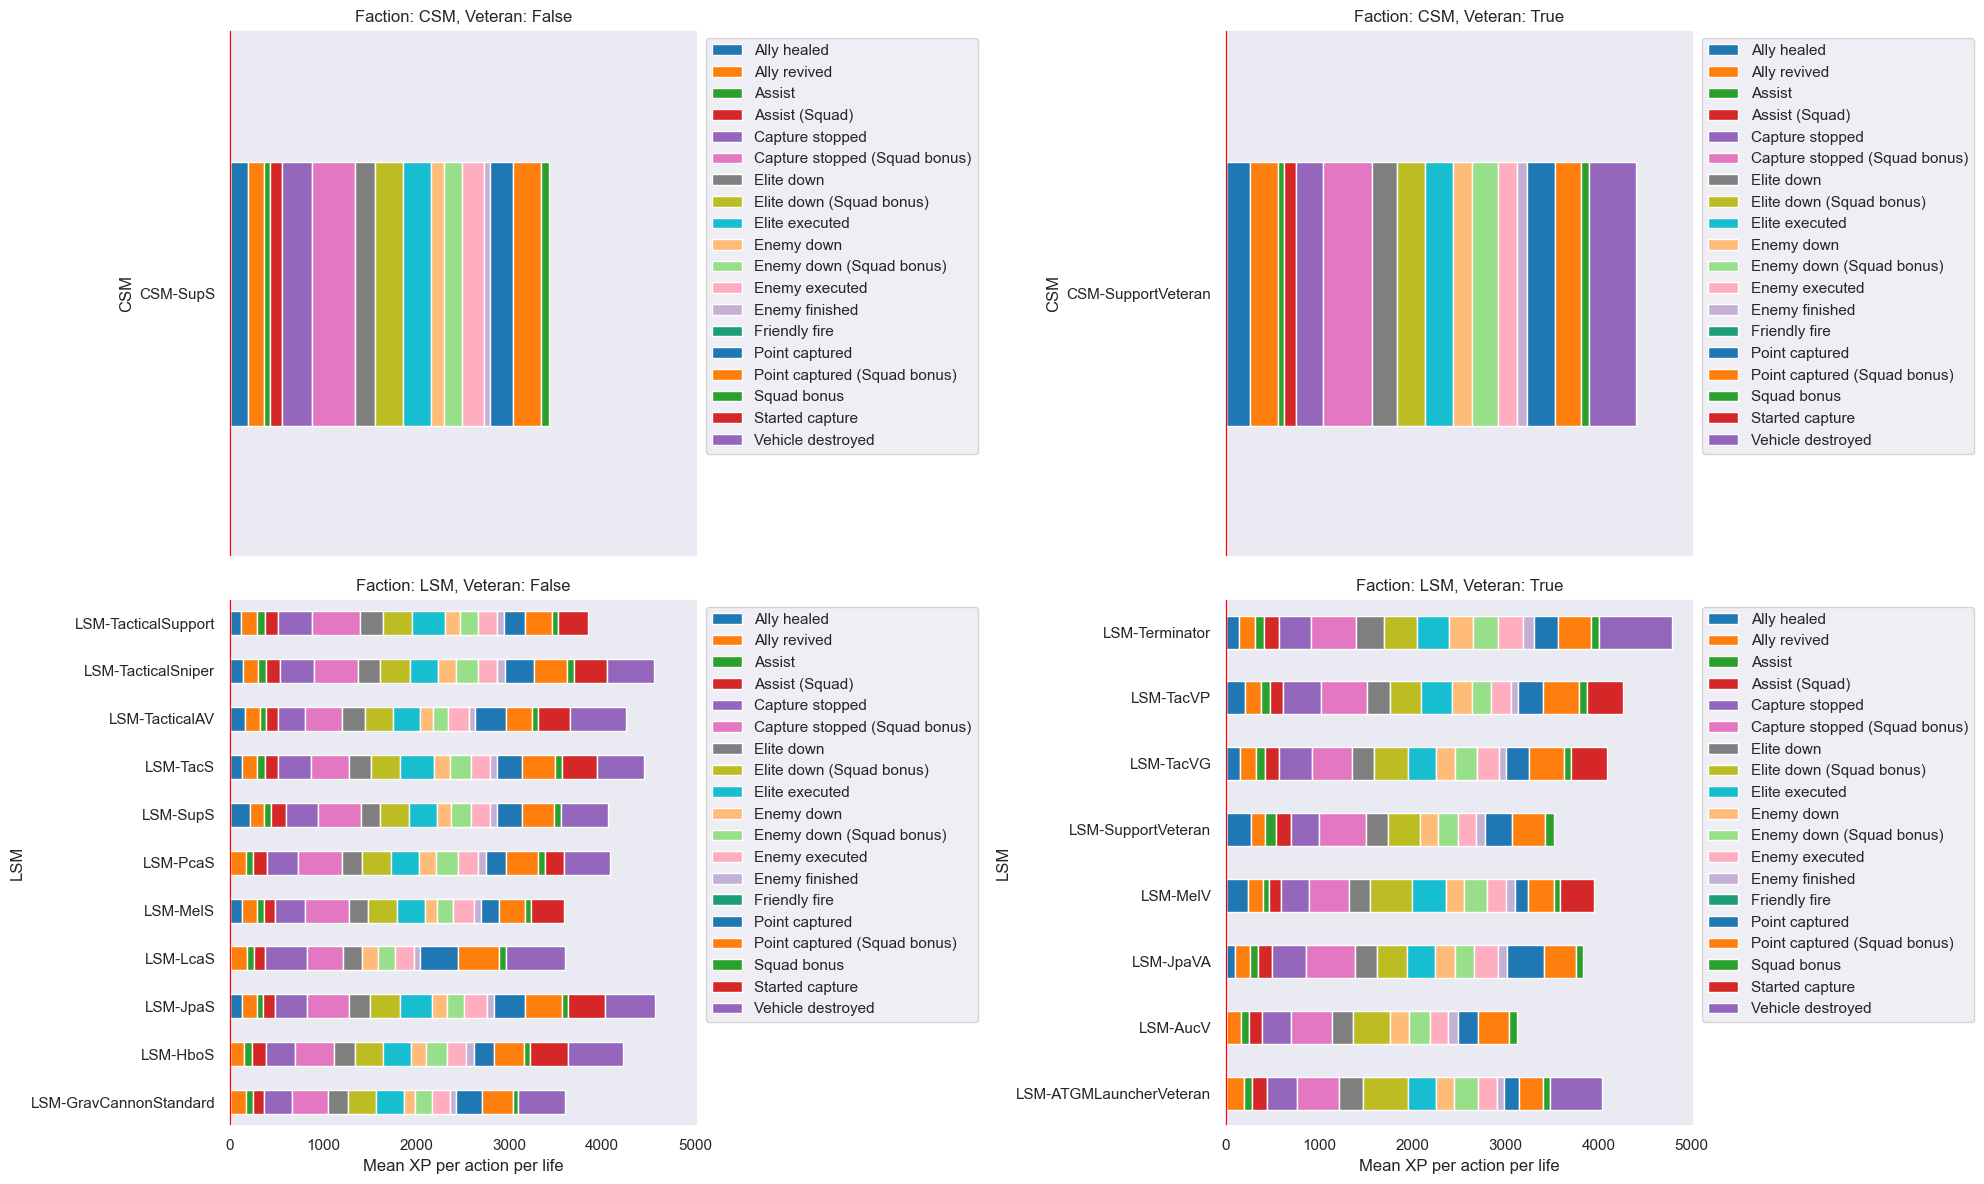

In [24]:
# Create a pivot table to reshape the data for plotting
pivot_xp_per_life_for_class_and_action = xp_per_life_for_class_and_action.reset_index()
pivot_xp_per_life_for_class_and_action = pivot_xp_per_life_for_class_and_action.pivot(
    index=['loadout', 'faction', 'is_veteran'], columns='action',
    values='mean_xp_per_life')
pivot_xp_per_life_for_class_and_action = pivot_xp_per_life_for_class_and_action.reset_index().set_index("loadout")

# Create a grid of subplots
fig, axes = plt.subplots(
    nrows=len(xp_per_pawn['faction'].unique()),
    ncols=len(xp_per_pawn['is_veteran'].unique()),
    figsize=(24, 16),
    sharex=share_x
)

# Define a custom color palette
custom_colors = [
    '#1f77b4',  # Blue
    '#ff7f0e',  # Orange
    '#2ca02c',  # Green
    '#d62728',  # Red
    '#9467bd',  # Purple
    '#e377c2',  # Pink
    '#7f7f7f',  # Gray
    '#bcbd22',  # Yellow-Green
    '#17becf',  # Cyan
    '#ffbb78',  # Light Orange
    '#98df8a',  # Light Green
    '#ffaec0',  # Light Pink
    '#c5b0d5',  # Light Purple
    '#1b9e77',  # Dark Green
]

# Grouping into subplots
for ((faction, veteran), subset), ax in zip(pivot_xp_per_life_for_class_and_action.groupby(['faction', 'is_veteran']),
                                            axes.flat):
    subset = subset.sort_values(by='loadout')  # Sort by 'loadout'
    subset = subset.drop(["faction", "is_veteran"], axis=1)

    # Create a rotated stacked barplot with the custom color palette
    subset.plot(kind='barh', stacked=True, figsize=(20, 12), color=custom_colors, ax=ax)

    # Set titles and axis labels
    ax.set_title(f'Faction: {faction}, Veteran: {veteran}')
    ax.set_xlabel('Mean XP per action per life')
    ax.set_ylabel(faction)

    # Set x-axis ticks for each subplot
    ax.tick_params(axis='x', labelbottom=True)
    ax.legend(bbox_to_anchor=(1, 1))

    ax.axvline(x=0, color='red')

# Adjust layout
plt.tight_layout()
plt.show()

## Analyzing KS ratios

In [25]:
kills_df = xp_df[xp_df["action"].isin(["Enemy down", "Убийство врага", "Elite down", "Убийство элиты"])]
kills_df.head()

,t,value,tps,tf,tl,tc,action,Type,match_ts,file,t-faction-class,t-is-veteran,tc_x,tc_y
1,ECRCharacter_SpaceMarine_C_2147477838-2024-04-...,100.0,PS_2147481031-2024-04-08T17-57-23.289921,LSM,GravCannonStandard,X=17639.260 Y=1743.280 Z=-1529.790,Enemy down,XP,2024-04-08T17-57-23.289921,2024-04-08T17-57-23.289921.json,LSM-GravCannonStandard,False,17639.26,1743.28
4,ECRCharacter_SpaceMarine_C_2147477659-2024-04-...,100.0,PS_2147482152-2024-04-08T17-57-23.289921,LSM,TacticalSniper,X=27179.620 Y=-8015.180 Z=320.060,Enemy down,XP,2024-04-08T17-57-23.289921,2024-04-08T17-57-23.289921.json,LSM-TacticalSniper,False,27179.62,-8015.18
8,ECRCharacter_SpaceMarine_C_2147476565-2024-04-...,100.0,PS_2147480283-2024-04-08T17-57-23.289921,LSM,JpaS,X=29404.630 Y=-8684.240 Z=320.010,Enemy down,XP,2024-04-08T17-57-23.289921,2024-04-08T17-57-23.289921.json,LSM-JpaS,False,29404.63,-8684.24
18,ECRCharacter_SpaceMarine_C_2147476565-2024-04-...,100.0,PS_2147480283-2024-04-08T17-57-23.289921,LSM,JpaS,X=27284.800 Y=-9689.660 Z=330.480,Enemy down,XP,2024-04-08T17-57-23.289921,2024-04-08T17-57-23.289921.json,LSM-JpaS,False,27284.80,-9689.66
21,ECRCharacter_SpaceMarine_C_2147477531-2024-04-...,100.0,PS_2147479569-2024-04-08T17-57-23.289921,LSM,TacticalSniper,X=27210.950 Y=-7824.490 Z=-737.940,Enemy down,XP,2024-04-08T17-57-23.289921,2024-04-08T17-57-23.289921.json,LSM-TacticalSniper,False,27210.95,-7824.49


In [26]:
kills_per_pawn = kills_df.groupby(["t"]).agg(
    kill_count=('t', 'count'),
    loadout=('t-faction-class', 'first'),
    faction=('tf', 'first'),
    is_veteran=('t-is-veteran', 'first')
)
kills_per_pawn.head()

,kill_count,loadout,faction,is_veteran
t,,,,
ECRCharacter_SpaceMarine_C_2147406127-2024-04-14T19-09-10.930586,1,LSM-TacS,LSM,False
ECRCharacter_SpaceMarine_C_2147406510-2024-04-14T19-09-10.930586,1,CSM-SupS,CSM,False
ECRCharacter_SpaceMarine_C_2147406813-2024-04-14T19-09-10.930586,1,LSM-TacticalSupport,LSM,False
ECRCharacter_SpaceMarine_C_2147407176-2024-04-14T19-09-10.930586,1,LSM-TacS,LSM,False
ECRCharacter_SpaceMarine_C_2147407305-2024-04-14T19-09-10.930586,1,CSM-SupportVeteran,CSM,True


In [27]:
kills_per_life_for_classes = kills_per_pawn.groupby("loadout").agg(
    mean_kills_per_life=('kill_count', 'mean'),
    std_kills_per_life=('kill_count', 'std')
)
kills_per_life_for_classes

,mean_kills_per_life,std_kills_per_life
loadout,,
CSM-SupS,1.401869,0.698513
CSM-SupportVeteran,2.272727,1.530521
LSM-ATGMLauncherVeteran,1.991150,1.472944
LSM-AucV,2.240602,1.523306
LSM-GravCannonStandard,1.243902,0.582258
LSM-HboS,1.670644,1.161457
LSM-JpaS,1.611491,1.046628
LSM-JpaVA,2.270677,2.100245
LSM-LcaS,1.769231,1.343610


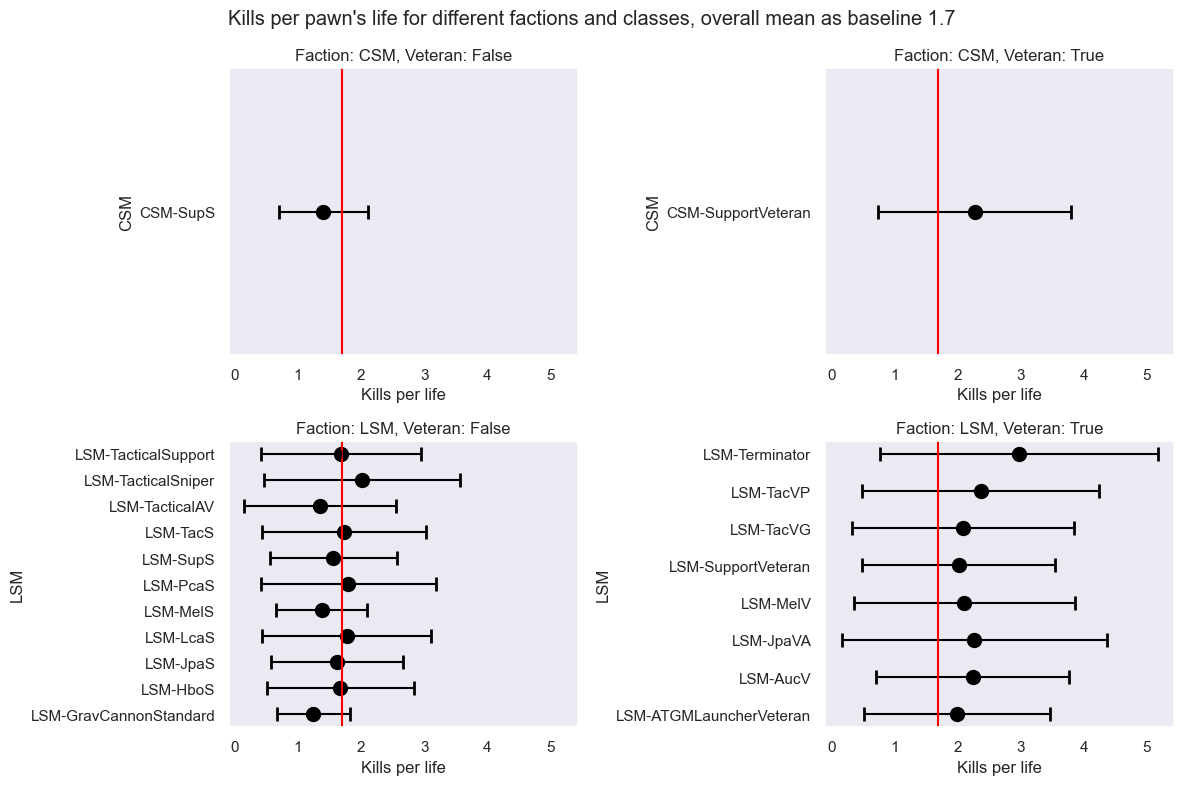

In [28]:
# Create a grid of subplots
fig, axes = plt.subplots(
    nrows=len(kills_per_pawn['faction'].unique()),
    ncols=len(kills_per_pawn['is_veteran'].unique()),
    figsize=(12, 8),
    sharex=share_x
)

mean_kps_per_non_vet_pawn = kills_per_pawn[~kills_per_pawn['is_veteran']]["kill_count"].mean()

# Grouping into subplots
for ((faction, veteran), subset), ax in zip(kills_per_pawn.groupby(['faction', 'is_veteran']), axes.flat):
    subset = subset.sort_values(by='loadout')  # Sort by 'loadout'

    grouped = subset.groupby('loadout')['kill_count']
    means = grouped.mean()
    stds = grouped.std()

    # Create a horizontal scatter plot for means
    ax.scatter(means, means.index, color='black', label='Mean', s=100, marker='o')  # Adjust the 's' parameter for size

    # Create vertical bars for standard deviation
    for i, (mean_val, std_val) in enumerate(zip(means, stds)):
        ax.errorbar(mean_val, i, xerr=std_val, fmt='|', color='black', capsize=5, capthick=2, label='Std Deviation')

    # Set titles and axis labels
    ax.set_title(f'Faction: {faction}, Veteran: {veteran}')
    ax.set_xlabel('Kills per life')
    ax.set_ylabel(faction)

    # Set x-axis ticks for each subplot
    ax.tick_params(axis='x', labelbottom=True)

    ax.axvline(x=mean_kps_per_non_vet_pawn, color='red')

plt.suptitle(f"Kills per pawn's life for different factions and classes, overall mean as baseline {mean_kps_per_non_vet_pawn:.1f}")
# Adjust layout
plt.tight_layout()
plt.show()

## Analyzing class frequencies

In [29]:
spawn_df = pd.DataFrame([el for el in raw_data if el["Type"] == "Spawn"])

In [30]:
class_spawns = spawn_df["t-faction-class"].value_counts()

<Axes: title={'center': 'Classes spawn frequency'}, ylabel='t-faction-class'>

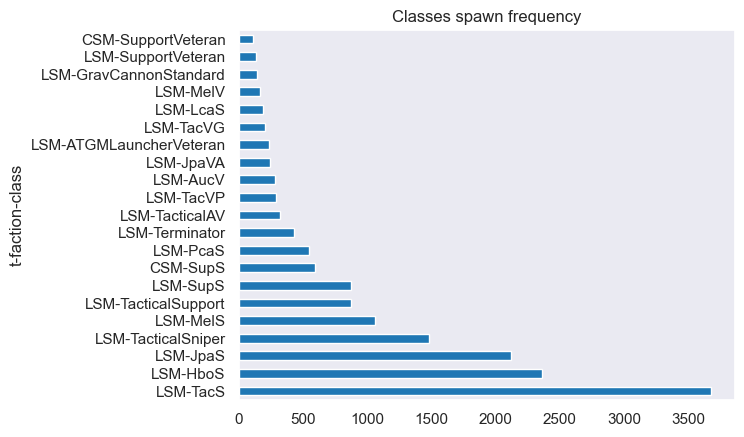

In [31]:
class_spawns.plot.barh(title="Classes spawn frequency")

# Maps and missions

In [6]:
faction_mapping = {
    "LSM": "LoyalSpaceMarines",
    "CSM": "ChaosSpaceMarines"
}

In [12]:
raw_match_end_data = []


def parse_team(team_string):
    try:
        team_data = json.loads(team_string)
    except:
        return None, None, None, None
    team_name = ",".join(sorted(team_data["alliance"]["factionNames"]))
    team_goal = team_data["goal"]
    team_score = team_data["score"]
    # team_max_score = team_data["maxScore"]
    team_max_score = 0
    return team_name, team_goal, team_score, team_max_score


def parse_winner(winner_string):
    try:
        winner_data = json.loads(winner_string)
    except:
        return None, None
    team_name = ",".join(sorted(winner_data["alliance"]["factionNames"]))
    team_goal = winner_data["goal"]
    return team_name, team_goal


def get_positive_xp_per_team(match_ts, team_name):
    if team_name is None:
        return None

    xp = 0
    for event in raw_data:
        if event["match_ts"] == match_ts and event["Type"] == "XP" and faction_mapping.get(
                event.get("tf")) in team_name and event["value"] > 0:
            xp += event["value"]
    return xp


# def get_kill_spawns_ratio_per_team(match_ts, team_name):
#     if team_name is None:
#         return None
#
#     spawns = 0
#     kills = 0
#     for event in raw_data:
#         if event["match_ts"] == match_ts and event["Type"] == "Spawn" and faction_mapping.get(event.get("tf")) in team_name:
#             spawns += 1
#         if event["match_ts"] == match_ts and event["Type"] == "XP" and faction_mapping.get(event.get("tf")) in team_name and event["action"] == "Enemy down":
#             kills += 1
#     return kills / spawns if spawns != 0 else None

won_lost_data = []
for el in old_raw_data["data"]:
    if el["Type"] == "WonLost":
        won_lost_data.append(el)

for el in tqdm(old_raw_data["data"]):
    if el["Type"] == "MatchEnd":
        match_ts = el["match_ts"]

        if "map" in el and "mission" in el:
            el["map-mission"] = el["map"] + "_" + el["mission"]

        if "t1" in el:
            el["t1_name"], el["t1_goal"], el["t1_score"], el["t1_max_score"] = parse_team(el["t1"])

            el.pop("t1")

            el["t1_xp"] = get_positive_xp_per_team(match_ts, el["t1_name"])
            # el["t1_ks_ratio"] = get_kill_spawns_ratio_per_team(match_ts, el["t1_name"])

        if "t2" in el:
            el["t2_name"], el["t2_goal"], el["t2_score"], el["t2_max_score"] = parse_team(el["t2"])
            el.pop("t2")

            el["t2_xp"] = get_positive_xp_per_team(match_ts, el["t2_name"])
            # el["t2_ks_ratio"] = get_kill_spawns_ratio_per_team(match_ts, el["t2_name"])

        if "t3" in el:
            el["t3_name"], el["t3_goal"], el["t3_score"], el["t3_max_score"] = parse_team(el["t3"])
            el.pop("t3")

            el["t3_xp"] = get_positive_xp_per_team(match_ts, el["t3_name"])
            # el["t3_ks_ratio"] = get_kill_spawns_ratio_per_team(match_ts, el["t3_name"])

        if "t4" in el:
            el["t4_name"], el["t4_goal"], el["t4_score"], el["t4_max_score"] = parse_team(el["t4"])
            el.pop("t4")

            el["t4_xp"] = get_positive_xp_per_team(match_ts, el["t4_name"])
            # el["t4_ks_ratio"] = get_kill_spawns_ratio_per_team(match_ts, el["t4_name"])

        if "winner" in el:
            el.pop("winner")

        team_names_to_goals = {
            el["t1_name"]: el["t1_goal"],
            el["t2_name"]: el["t2_goal"],
            el["t3_name"]: el["t3_goal"],
            el["t4_name"]: el["t4_goal"]
        }

        winners = []
        for el2 in won_lost_data:
            if el2["match_ts"] == match_ts and el2["result"] == "won":
                winners.append(el2["faction"])

        el["winner_name"] = ",".join(sorted([faction_mapping.get(el) for el in winners]))
        el["winner_goal"] = team_names_to_goals.get(el["winner_name"])

        raw_match_end_data.append(el)


100%|██████████| 681049/681049 [00:42<00:00, 16181.95it/s]


In [25]:
match_end_df = pd.DataFrame(raw_match_end_data)

# Account for matches with winner only
match_end_df = match_end_df[match_end_df["winner_name"] != ""]

In [24]:
# match_end_df[match_end_df["winner_name"] == ""]

,map,mission,pa,ts,duration,minduration,maxduration,Type,match_ts,file,...,t3_max_score,t3_xp,t4_name,t4_goal,t4_score,t4_max_score,t4_xp,winner_name,winner_goal,t1_xp
27,CanyonWasteyard,B_GM_Supremacy_Canyon_C,,,600.0,600.0,1500.0,MatchEnd,2024-04-15T19-26-07.189262,2024-04-15T19-26-07.189262.json,...,None,None,None,None,None,None,None,,None,0.0
32,CanyonWasteyard,B_GM_Supremacy_Canyon_C,,,600.0,600.0,1500.0,MatchEnd,2024-04-18T18-29-44.992896,2024-04-18T18-29-44.992896.json,...,None,None,None,None,None,None,None,,None,0.0
49,CycladonComplex,B_GM_Supremacy_Cycladon_C,,,600.0,600.0,1230.0,MatchEnd,2024-04-26T15-16-11.634466,2024-04-26T15-16-11.634466.json,...,None,None,None,None,None,None,None,,None,0.0
67,NexusCitadel,B_GM_Duel_Nexus_C,,,180.0,180.0,180.0,MatchEnd,2024-04-28T21-58-45.605822,2024-04-28T21-58-45.605822.json,...,None,None,None,None,None,None,None,,None,0.0
68,NexusCitadel,B_GM_Elimination_Nexus_C,,,900.0,900.0,900.0,MatchEnd,2024-04-29T13-20-39.241061,2024-04-29T13-20-39.241061.json,...,None,None,None,None,None,None,None,,None,2151.0
69,NexusCitadel,B_GM_Elimination_Nexus_C,,,900.0,900.0,900.0,MatchEnd,2024-04-30T02-01-23.877632,2024-04-30T02-01-23.877632.json,...,None,None,None,None,None,None,None,,None,0.0
71,NexusCitadel,B_GM_Elimination_Nexus_C,,,900.0,900.0,900.0,MatchEnd,2024-05-02T13-50-54.329985,2024-05-02T13-50-54.329985.json,...,None,None,None,None,None,None,None,,None,21924.0
82,ZedekSmall,B_GM_DeepStrike_ZedekSmall_C,,,540.0,540.0,1081.0,MatchEnd,2024-05-05T18-04-30.016117,2024-05-05T18-04-30.016117.json,...,None,None,None,None,None,None,None,,None,0.0
88,RailgateRavine,B_GM_Duel_Railgate_C,,,180.0,180.0,180.0,MatchEnd,2024-05-05T19-46-37.880355,2024-05-05T19-46-37.880355.json,...,None,None,None,None,None,None,None,,None,0.0
89,NexusCitadel,B_GM_Duel_Nexus_C,,,180.0,180.0,180.0,MatchEnd,2024-05-09T17-50-10.685108,2024-05-09T17-50-10.685108.json,...,None,None,None,None,None,None,None,,None,0.0


In [31]:
match_end_df[match_end_df["map"] == "CanyonWasteyard"]

,map,mission,pa,ts,duration,minduration,maxduration,Type,match_ts,file,...,t3_max_score,t3_xp,t4_name,t4_goal,t4_score,t4_max_score,t4_xp,winner_name,winner_goal,t1_xp
0,CanyonWasteyard,B_GM_Supremacy_Canyon_C,,,900.0,600.0,1500.0,MatchEnd,2024-04-08T17-57-23.289921,2024-04-08T17-57-23.289921.json,...,None,None,None,None,None,None,None,ChaosSpaceMarines,Defender,NaN
5,CanyonWasteyard,B_GM_HoldTheLine_Canyon_C,,,1020.0,600.0,1230.0,MatchEnd,2024-04-08T20-06-40.070965,2024-04-08T20-06-40.070965.json,...,None,None,None,None,None,None,None,ChaosSpaceMarines,Attacker,815.0
8,CanyonWasteyard,B_GM_Domination_Canyon_C,,,2100.0,2100.0,2100.0,MatchEnd,2024-04-12T18-03-12.027869,2024-04-12T18-03-12.027869.json,...,None,None,None,None,None,None,None,ChaosSpaceMarines,Standard,46105.0
20,CanyonWasteyard,B_GM_Domination_Canyon_C,,,2100.0,2100.0,2100.0,MatchEnd,2024-04-14T19-24-55.631942,2024-04-14T19-24-55.631942.json,...,None,None,None,None,None,None,None,ChaosSpaceMarines,Standard,73784.0
29,CanyonWasteyard,B_GM_Domination_Canyon_C,,,2100.0,2100.0,2100.0,MatchEnd,2024-04-15T20-31-44.891284,2024-04-15T20-31-44.891284.json,...,None,None,None,None,None,None,None,LoyalSpaceMarines,Standard,47362.0
52,CanyonWasteyard,B_GM_HoldTheLine_Canyon_C,,,1020.0,600.0,1230.0,MatchEnd,2024-04-26T19-07-55.552585,2024-04-26T19-07-55.552585.json,...,None,None,None,None,None,None,None,LoyalSpaceMarines,Attacker,78236.0
60,CanyonWasteyard,B_GM_Domination_Canyon_C,,,2100.0,2100.0,2100.0,MatchEnd,2024-04-28T18-48-03.798762,2024-04-28T18-48-03.798762.json,...,None,None,None,None,None,None,None,ChaosSpaceMarines,Standard,4979.0
77,CanyonWasteyard,B_GM_Supremacy_Canyon_C,,,1500.0,600.0,1500.0,MatchEnd,2024-05-02T19-50-15.871379,2024-05-02T19-50-15.871379.json,...,None,None,None,None,None,None,None,ChaosSpaceMarines,Attacker,6505.0
84,CanyonWasteyard,B_GM_Domination_Canyon_C,,,2100.0,2100.0,2100.0,MatchEnd,2024-05-05T18-58-00.332866,2024-05-05T18-58-00.332866.json,...,None,None,None,None,None,None,None,ChaosSpaceMarines,Standard,1431.0
100,CanyonWasteyard,B_GM_HoldTheLine_Canyon_C,,,600.0,600.0,1230.0,MatchEnd,2024-05-11T18-31-25.701755,2024-05-11T18-31-25.701755.json,...,None,None,None,None,None,None,None,LoyalSpaceMarines,Defender,1879.0


## Preferred missions and maps

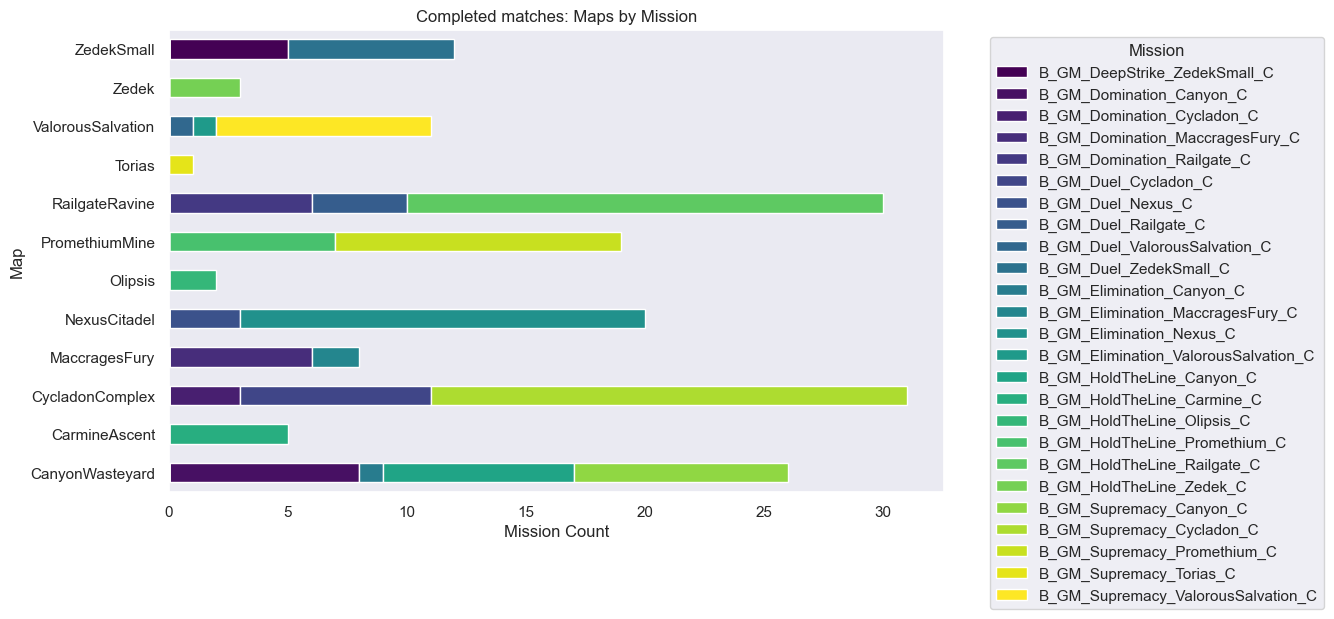

In [28]:
# Get the counts of each mission for each map
mission_counts = match_end_df.groupby(['map', 'mission']).size().unstack(fill_value=0)

# Create a horizontal bar plot
ax = mission_counts.plot(kind='barh', stacked=True, colormap='viridis', figsize=(10, 6))

# Customize the plot
ax.set_xlabel('Mission Count')
ax.set_ylabel('Map')
ax.set_title('Completed matches: Maps by Mission')

# Move the legend outside the plot
ax.legend(title='Mission', bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.show()

## Teams Win Rates

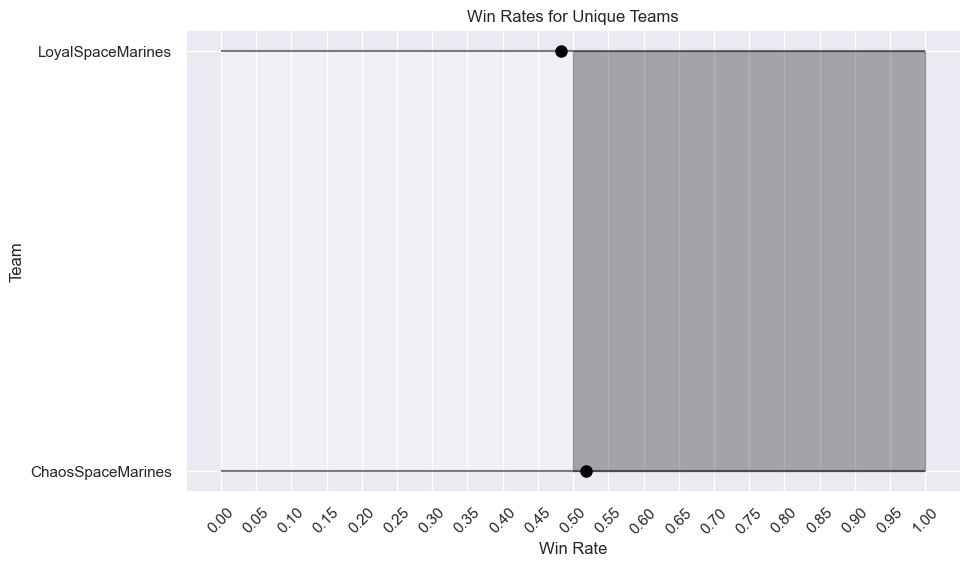

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a DataFrame "match_end_df" with columns "winner_name", "t1_name", "t2_name", "t3_name", and "t4_name"

# Get all the unique strings from the DataFrame
all_teams = [s for s in match_end_df[["t1_name", "t2_name", "t3_name", "t4_name"]].values.ravel() if s]
unique_teams = pd.unique(all_teams)

# Create a dictionary to store the win rates for each string
win_rates = {}

# Calculate win rates for each string
for team in unique_teams:
    total_matches = match_end_df[
        (match_end_df["t1_name"] == team) |
        (match_end_df["t2_name"] == team) |
        (match_end_df["t3_name"] == team) |
        (match_end_df["t4_name"] == team)
        ]["winner_name"].count()


    wins = match_end_df[match_end_df["winner_name"] == team]["winner_name"].count()

    win_rate = wins / total_matches if total_matches > 0 else 0
    win_rates[team] = win_rate

# Convert the dictionary to a DataFrame
win_rates_df = pd.DataFrame(list(win_rates.items()), columns=["Team", "Win Rate"])

# Sort the DataFrame by win rate
win_rates_df = win_rates_df.sort_values(by="Win Rate", ascending=False)

# Create a bar plot
plt.figure(figsize=(10, 6))
# Plot horizontal lines for each 'map-mission'
plt.hlines(y=range(len(unique_teams)), xmin=0, xmax=1, color='k', alpha=0.5)

# Plot points representing the frequency of 'Defender' winners
plt.plot(win_rates_df["Win Rate"], win_rates_df["Team"], marker='o', color='black', linestyle='None', markersize=8)

# Fill the area left of 0.5 with red and right of 0.5 with blue
plt.fill_betweenx([0, len(unique_teams) - 1], 0, 0.5, color='white', alpha=0.3)
plt.fill_betweenx([0, len(unique_teams) - 1], 0.5, 1, color='black', alpha=0.3)

plt.xticks(np.arange(0, 1.05, 0.05), rotation=45)
plt.grid()

# Set labels for axes and title
plt.xlabel("Win Rate")
plt.ylabel("Team")
plt.title("Win Rates for Unique Teams")

# Display the plot
plt.show()

## Attacker defender matches

In [29]:
attacker_defender_match_end_df = match_end_df[match_end_df["winner_goal"].isin(["Attacker", "Defender"])]

In [30]:
attacker_defender_match_end_df[attacker_defender_match_end_df["map"] == "CanyonWasteyard"]

,map,mission,pa,ts,duration,minduration,maxduration,Type,match_ts,file,...,t3_max_score,t3_xp,t4_name,t4_goal,t4_score,t4_max_score,t4_xp,winner_name,winner_goal,t1_xp
0,CanyonWasteyard,B_GM_Supremacy_Canyon_C,,,900.0,600.0,1500.0,MatchEnd,2024-04-08T17-57-23.289921,2024-04-08T17-57-23.289921.json,...,None,None,None,None,None,None,None,ChaosSpaceMarines,Defender,NaN
5,CanyonWasteyard,B_GM_HoldTheLine_Canyon_C,,,1020.0,600.0,1230.0,MatchEnd,2024-04-08T20-06-40.070965,2024-04-08T20-06-40.070965.json,...,None,None,None,None,None,None,None,ChaosSpaceMarines,Attacker,815.0
52,CanyonWasteyard,B_GM_HoldTheLine_Canyon_C,,,1020.0,600.0,1230.0,MatchEnd,2024-04-26T19-07-55.552585,2024-04-26T19-07-55.552585.json,...,None,None,None,None,None,None,None,LoyalSpaceMarines,Attacker,78236.0
77,CanyonWasteyard,B_GM_Supremacy_Canyon_C,,,1500.0,600.0,1500.0,MatchEnd,2024-05-02T19-50-15.871379,2024-05-02T19-50-15.871379.json,...,None,None,None,None,None,None,None,ChaosSpaceMarines,Attacker,6505.0
100,CanyonWasteyard,B_GM_HoldTheLine_Canyon_C,,,600.0,600.0,1230.0,MatchEnd,2024-05-11T18-31-25.701755,2024-05-11T18-31-25.701755.json,...,None,None,None,None,None,None,None,LoyalSpaceMarines,Defender,1879.0
104,CanyonWasteyard,B_GM_Supremacy_Canyon_C,,,1200.0,600.0,1500.0,MatchEnd,2024-05-11T20-00-07.116675,2024-05-11T20-00-07.116675.json,...,None,None,None,None,None,None,None,LoyalSpaceMarines,Defender,900.0
116,CanyonWasteyard,B_GM_HoldTheLine_Canyon_C,,,1020.0,600.0,1230.0,MatchEnd,2024-05-16T19-12-54.715760,2024-05-16T19-12-54.715760.json,...,None,None,None,None,None,None,None,ChaosSpaceMarines,Attacker,6404.0
121,CanyonWasteyard,B_GM_HoldTheLine_Canyon_C,,,1020.0,600.0,1230.0,MatchEnd,2024-05-18T13-15-34.532870,2024-05-18T13-15-34.532870.json,...,None,None,None,None,None,None,None,ChaosSpaceMarines,Attacker,1500.0
122,CanyonWasteyard,B_GM_HoldTheLine_Canyon_C,,,1020.0,600.0,1230.0,MatchEnd,2024-05-18T13-33-55.283226,2024-05-18T13-33-55.283226.json,...,None,None,None,None,None,None,None,ChaosSpaceMarines,Attacker,550.0
130,CanyonWasteyard,B_GM_Supremacy_Canyon_C,,,1500.0,600.0,1500.0,MatchEnd,2024-05-22T18-37-45.634016,2024-05-22T18-37-45.634016.json,...,None,None,None,None,None,None,None,LoyalSpaceMarines,Attacker,86385.0


In [32]:
attacker_defender_match_end_df["def_att_xp_ratio"] = attacker_defender_match_end_df["t2_xp"] / attacker_defender_match_end_df["t1_xp"]

# # attacker_defender_match_end_df["def_att_ks_ratio"] = attacker_defender_match_end_df["t2_ks_ratio"] / attacker_defender_match_end_df["t1_ks_ratio"]


# attacker_defender_match_end_df = attacker_defender_match_end_df[attacker_defender_match_end_df['def_att_xp_ratio'].notna()]
# attacker_defender_match_end_df = attacker_defender_match_end_df[attacker_defender_match_end_df['def_att_ks_ratio'].notna()]

### Win Rates

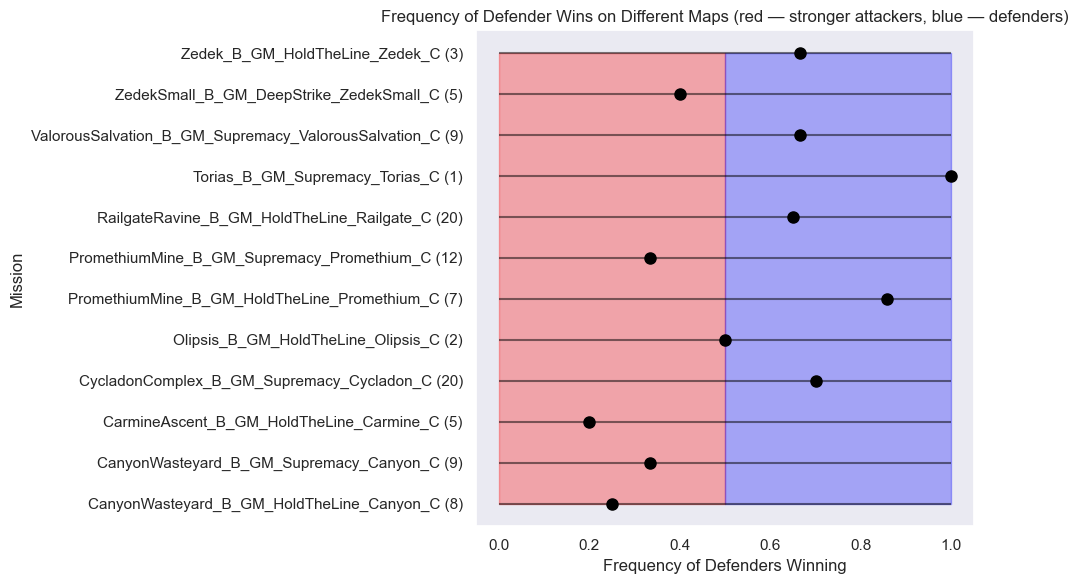

In [33]:
# Group the data by 'map-mission' and calculate the frequency of 'Defender' winners
frequency_df = attacker_defender_match_end_df.groupby('map-mission')['winner_goal'].apply(
    lambda x: (x == 'Defender').mean()).reset_index()
frequency_df.rename(columns={'winner_goal': 'Defender_Frequency'}, inplace=True)

# Sort the DataFrame by 'Defender_Frequency'
frequency_df = frequency_df.sort_values(by='Defender_Frequency')

# Get the count of rows for each mission
mission_counts = attacker_defender_match_end_df['map-mission'].value_counts().reindex(
    frequency_df['map-mission']).fillna(0)

# Create a figure and axes for the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot horizontal lines for each 'map-mission'
ax.hlines(y=frequency_df.index, xmin=0, xmax=1, color='k', alpha=0.5)

# Plot points representing the frequency of 'Defender' winners
ax.plot(frequency_df['Defender_Frequency'], frequency_df.index, marker='o', color='black', linestyle='None',
        markersize=8)

# Fill the area left of 0.5 with red and right of 0.5 with blue
ax.fill_betweenx([0, len(frequency_df.index) - 1], 0, 0.5, color='red', alpha=0.3)
ax.fill_betweenx([0, len(frequency_df.index) - 1], 0.5, 1, color='blue', alpha=0.3)

# Customize the plot
ax.set_ylabel('Mission')
ax.set_xlabel('Frequency of Defenders Winning')
ax.set_title('Frequency of Defender Wins on Different Maps (red — stronger attackers, blue — defenders)')

# Set y-ticks to 'map-mission' values
y_ticks = [f"{mission} ({count})" for mission, count in zip(frequency_df['map-mission'], mission_counts)]
plt.yticks(frequency_df.index, y_ticks)

# Display the plot
plt.tight_layout()
plt.show()

## XP ratios

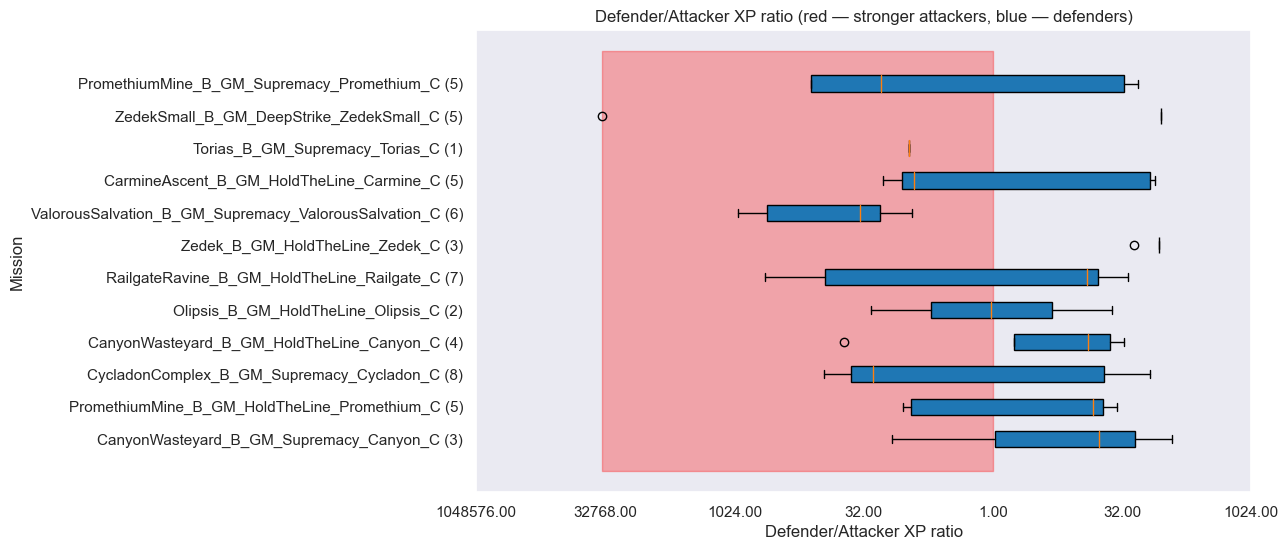

In [41]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Convert the "def_att_xp_ratio" column to a logarithmic scale
attacker_defender_match_end_df['def_att_xp_ratio_log2'] = np.log2(attacker_defender_match_end_df['def_att_xp_ratio'])

# Group the data by "map-mission" and extract unique labels
unique_labels = attacker_defender_match_end_df['map-mission'].unique()

unique_labels_counts = attacker_defender_match_end_df['map-mission'].value_counts().reindex(unique_labels).fillna(0)

# Create a boxplot with logarithmic x-axis
boxplot = ax.boxplot(
    [attacker_defender_match_end_df[attacker_defender_match_end_df['map-mission'] == label]['def_att_xp_ratio_log2'] for
     label in unique_labels],
    vert=False,
    patch_artist=True
)

# Fill the area left of 0.5 with red and right of 0.5 with blue
ax.fill_betweenx([0, len(unique_labels) + 1],
                 min([x for x in attacker_defender_match_end_df['def_att_xp_ratio_log2'] if x != -np.inf]), 0,
                 color='red', alpha=0.3)
ax.fill_betweenx([0, len(unique_labels) + 1], 0, max(attacker_defender_match_end_df['def_att_xp_ratio_log2']),
                 color='blue', alpha=0.3)

# Set y-ticks to 'map-mission' values
y_ticks = [f"{mission} ({count})" for mission, count in zip(unique_labels, unique_labels_counts)]
plt.yticks(range(1, len(unique_labels) + 1), y_ticks)

# Set logarithmic tick labels on the x-axis
xticks, _ = plt.xticks()
xtick_labels = [f'{2 ** abs(x):.2f}'.format(x) for x in xticks]
plt.xticks(xticks, xtick_labels)

# Set labels for axes and title
ax.set_xlabel('Defender/Attacker XP ratio')
ax.set_ylabel('Mission')
ax.set_title('Defender/Attacker XP ratio (red — stronger attackers, blue — defenders)')

# Show the plot
plt.show()

### Kill/Spawn ratios

In [ ]:
# # Create a figure and axis
# fig, ax = plt.subplots(figsize=(10, 6))
#
# # Convert the "def_att_xp_ratio" column to a logarithmic scale
# attacker_defender_match_end_df['def_att_ks_ratio_log2'] = np.log2(attacker_defender_match_end_df['def_att_ks_ratio'])
#
# # Group the data by "map-mission" and extract unique labels
# unique_labels = attacker_defender_match_end_df['map-mission'].unique()
#
# unique_labels_counts = attacker_defender_match_end_df['map-mission'].value_counts().reindex(unique_labels).fillna(0)
#
# # Create a boxplot with logarithmic x-axis
# boxplot = ax.boxplot(
#     [attacker_defender_match_end_df[attacker_defender_match_end_df['map-mission'] == label]['def_att_ks_ratio_log2'] for label in unique_labels],
#     vert=False,
#     patch_artist=True
# )
#
# # Fill the area left of 0.5 with red and right of 0.5 with blue
# ax.fill_betweenx([0, len(unique_labels) + 1], min([x for x in attacker_defender_match_end_df['def_att_ks_ratio_log2'] if x != -np.inf]), 0, color='red', alpha=0.3)
# ax.fill_betweenx([0, len(unique_labels) + 1], 0, max(attacker_defender_match_end_df['def_att_ks_ratio_log2']), color='blue', alpha=0.3)
#
# # Set y-ticks to 'map-mission' values
# y_ticks = [f"{mission} ({count})" for mission, count in zip(unique_labels, unique_labels_counts)]
# plt.yticks(range(1, len(unique_labels) + 1), y_ticks)
#
# # Set logarithmic tick labels on the x-axis
# xticks, _ = plt.xticks()
# xtick_labels = [f'{2**abs(x):.1f}'.format(x) for x in xticks]
# plt.xticks(xticks, xtick_labels)
#
# # Set labels for axes and title
# ax.set_xlabel('Defender/Attacker Kill/Spawn ratio')
# ax.set_ylabel('Mission')
# ax.set_title('Defender/Attacker KS ratio (red — stronger attackers, blue — defenders)')
#
# # Show the plot
# plt.show()

## Symmetrical matches

In [ ]:
symmetrical_match_end_df = match_end_df[match_end_df["winner_goal"] == "Standard"]

In [ ]:
symmetrical_match_end_df["max_xp_ratio"] = symmetrical_match_end_df[["t1_xp", "t2_xp", "t3_xp", "t4_xp"]].max(axis=1) / symmetrical_match_end_df[["t1_xp", "t2_xp", "t3_xp", "t4_xp"]].replace(0,
                                                                       None).min(axis=1)

# symmetrical_match_end_df["max_ks_ratio"] = symmetrical_match_end_df[["t1_ks_ratio", "t2_ks_ratio", "t3_ks_ratio", "t4_ks_ratio"]].max(axis=1) / symmetrical_match_end_df[["t1_ks_ratio", "t2_ks_ratio", "t3_ks_ratio", "t4_ks_ratio"]].replace(0, None).min(axis=1)

symmetrical_match_end_df = symmetrical_match_end_df[symmetrical_match_end_df['max_xp_ratio'].notna()]
# symmetrical_match_end_df = symmetrical_match_end_df[symmetrical_match_end_df['max_ks_ratio'].notna()]

## Win rates

In [ ]:
# Group the data by 'map-mission' and calculate the frequency of 'Defender' winners
frequency_df = symmetrical_match_end_df.groupby('map-mission').apply(
    lambda x: (x['winner_name'] == x['t1_name']).mean()).reset_index()
frequency_df.rename(columns={0: 'T1_Frequency'}, inplace=True)

# Get the count of rows for each mission
mission_counts = symmetrical_match_end_df['map-mission'].value_counts().reindex(frequency_df['map-mission']).fillna(0)

# Sort the DataFrame by 'T1_Frequency'
frequency_df = frequency_df.sort_values(by='T1_Frequency')

# Create a figure and axes for the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot horizontal lines for each 'map-mission'
ax.hlines(y=frequency_df.index, xmin=0, xmax=1, color='k', alpha=0.5)

# Plot points representing the frequency of 'Defender' winners
ax.plot(frequency_df['T1_Frequency'], frequency_df.index, marker='o', color='black', linestyle='None', markersize=8)

# Fill the area left of 0.5 with red and right of 0.5 with blue
ax.fill_betweenx([0, len(frequency_df.index) - 1], 0, 0.5, color='red', alpha=0.3)
ax.fill_betweenx([0, len(frequency_df.index) - 1], 0.5, 1, color='blue', alpha=0.3)

# Customize the plot
ax.set_ylabel('Mission')
ax.set_xlabel('Frequency of Team 1 Winning')
ax.set_title(
    'Frequency of Team 1 Wins on Different Maps (red — weaker team 1 (previous attackers), blue — team 1 is strong)')

# Set y-ticks to 'map-mission' values and add mission row counts to labels
y_ticks = [f"{mission} ({count})" for mission, count in zip(frequency_df['map-mission'], mission_counts)]
plt.yticks(frequency_df.index, y_ticks)

# Display the plot
plt.tight_layout()
plt.show()

## XP Ratios

In [ ]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Convert the "def_att_xp_ratio" column to a logarithmic scale
symmetrical_match_end_df['max_xp_ratio_log2'] = np.log2(np.float32(symmetrical_match_end_df['max_xp_ratio']))

# Group the data by "map-mission" and extract unique labels
unique_labels = symmetrical_match_end_df['map-mission'].unique()

unique_labels_counts = symmetrical_match_end_df['map-mission'].value_counts().reindex(unique_labels).fillna(0)

# Create a boxplot with logarithmic x-axis
boxplot = ax.boxplot(
    [symmetrical_match_end_df[symmetrical_match_end_df['map-mission'] == label]['max_xp_ratio_log2'] for label in
     unique_labels],
    vert=False,
    patch_artist=True
)

# Set y-ticks to 'map-mission' values
y_ticks = [f"{mission} ({count})" for mission, count in zip(unique_labels, unique_labels_counts)]
plt.yticks(range(1, len(unique_labels) + 1), y_ticks)

# Set logarithmic tick labels on the x-axis
xticks, _ = plt.xticks()
xtick_labels = [f'{2 ** abs(x):.2f}'.format(x) for x in xticks]
plt.xticks(xticks, xtick_labels)

# Set labels for axes and title
ax.set_xlabel('Max between teams XP ratio')
ax.set_ylabel('Mission')
ax.set_title('Max between teams XP ratio')

# Show the plot
plt.show()

## KS ratios

In [ ]:
# # Create a figure and axis
# fig, ax = plt.subplots(figsize=(10, 6))
#
# # Convert the "def_att_xp_ratio" column to a logarithmic scale
# symmetrical_match_end_df['max_ks_ratio_log2'] = np.log2(np.float32(symmetrical_match_end_df['max_ks_ratio']))
#
# # Group the data by "map-mission" and extract unique labels
# unique_labels = symmetrical_match_end_df['map-mission'].unique()
#
# unique_labels_counts = symmetrical_match_end_df['map-mission'].value_counts().reindex(unique_labels).fillna(0)
#
# # Create a boxplot with logarithmic x-axis
# boxplot = ax.boxplot(
#     [symmetrical_match_end_df[symmetrical_match_end_df['map-mission'] == label]['max_ks_ratio_log2'] for label in unique_labels],
#     vert=False,
#     patch_artist=True
# )
#
# # Set y-ticks to 'map-mission' values
# y_ticks = [f"{mission} ({count})" for mission, count in zip(unique_labels, unique_labels_counts)]
# plt.yticks(range(1, len(unique_labels) + 1), y_ticks)
#
# # Set logarithmic tick labels on the x-axis
# xticks, _ = plt.xticks()
# xtick_labels = [f'{2**abs(x):.2f}'.format(x) for x in xticks]
# plt.xticks(xticks, xtick_labels)
#
# # Set labels for axes and title
# ax.set_xlabel('Max between teams KS ratio')
# ax.set_ylabel('Mission')
# ax.set_title('Max between teams KS ratio')
#
# # Show the plot
# plt.show()

# Heatmaps

## Damage dealers

In [ ]:
x_points = list(damage_df["ic_x"])
y_points = list(damage_df["ic_y"])

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

# Create a 2D histogram to represent point density
heatmap, xedges, yedges = np.histogram2d(x_points, y_points, bins=100)

# Smooth the heatmap using Gaussian convolution
from scipy.ndimage import gaussian_filter

heatmap = gaussian_filter(heatmap, sigma=3)

# Define a custom colormap (blue, yellow, red)
colors = [(0, 'blue'), (0.5, 'yellow'), (1, 'red')]
custom_cmap = LinearSegmentedColormap.from_list('custom', colors)

# Create the heatmap plot
plt.imshow(heatmap.T, origin='lower', extent=[0, xedges.max(), 0, yedges.max()], cmap=custom_cmap)
plt.colorbar(label='Point Density')  # Add a colorbar for reference
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Damage Dealers Point Density Heatmap')

plt.show()